# Word Embeddings 

Document classification with Gensim
Classifying movie plots by genre using word embeddings techniques in gensim .



Uses 7 techniques:

-Bag of words

-Character n-grams

-TF-IDF

-doc2vec

-Deep IR

In [ ]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
import seaborn as sns

%matplotlib inline

In [3]:
# Load the dataset
df = pd.read_csv('/home/bibin/MAI/4th sem/Semantic/movies.csv')

# Sample the dataset to df_sampled
df_sampled = df.sample(frac=0.25, replace=False, random_state=1)

In [4]:
df_sampled.head()

Unnamed: 0        genre  \
10689       10689  documentary   
32392       32392        short   
47445       47445        short   
11729       11729    adventure   
1298         1298  documentary   

                                             description  
10689  This documentary film is a heartfelt glimpse a...  
32392  According to an old Chinese fairytale, the god...  
47445  In 1929, in Chicago, 12 year old Larry Adler w...  
11729  England Cricket hero Freddie Flintoff spends e...  
1298   Three gravediggers lovingly maintain the peace...

In [5]:
# Replace low-frequency genres with 'other' in df_sampled
threshold = 390  # Define your threshold
genre_counts = df_sampled['genre'].value_counts()
small_genres = genre_counts[genre_counts < threshold].index
df_sampled['genre'] = df_sampled['genre'].replace(small_genres, 'other')

In [20]:
unique_genres = df_sampled['genre'].unique()

# display the list of unique genres
print(unique_genres.tolist())

['documentary', 'short', 'other', 'drama', 'comedy', 'horror']


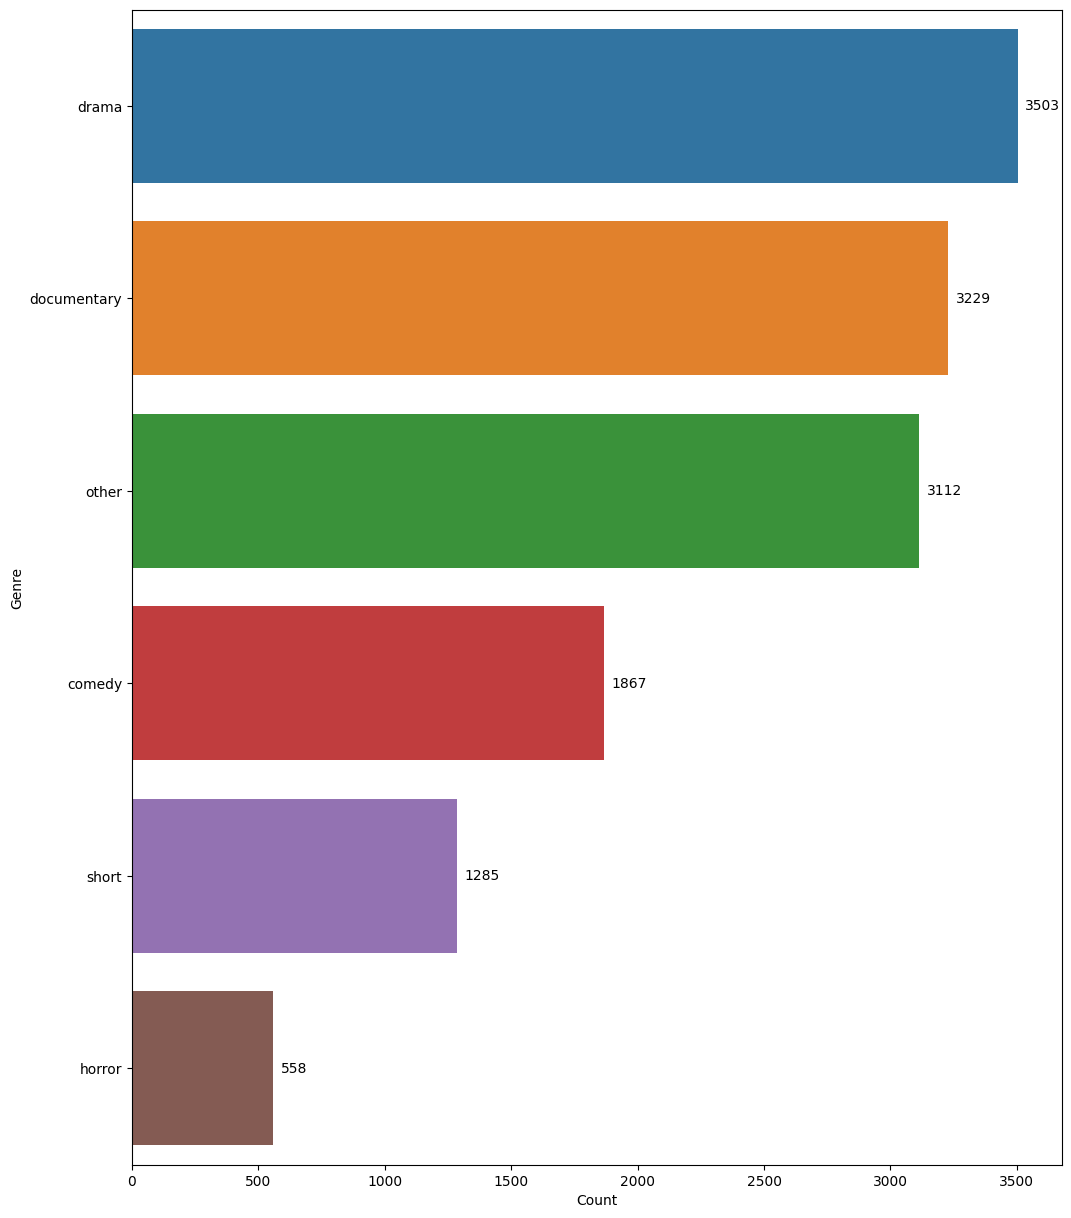

In [8]:
# Count the occurrences of each genre
genre_counts = df_sampled['genre'].value_counts()

# Create a dataframe with this count data
genres_df_sampled = genre_counts.reset_index()
genres_df_sampled.columns = ['Genre', 'Count']

# Sort the dataframe by the 'Count' column in descending order for plotting
genres_df_sampled = genres_df_sampled.sort_values('Count', ascending=False)

# Plotting with the count displayed on each bar
plt.figure(figsize=(12,15))
ax = sns.barplot(data=genres_df_sampled, x='Count', y='Genre')

# Adding the text labels for each bar
for p in ax.patches:
    ax.annotate(f"{int(p.get_width())}", 
                (p.get_width() + 3, p.get_y() + p.get_height() / 2), 
                xytext=(5, 0),  # 5 points horizontal offset
                textcoords='offset points',
                ha='left', 
                va='center')

ax.set(ylabel='Genre', xlabel='Count')
plt.show()

In [9]:
def print_plot(index):
    example = df[df.index == index][['description', 'genre']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Genre:', example[1])

In [10]:
print_plot(12)

A sister's breast cancer diagnosis and her brother's need to take action. Highlighting the events that took place during Franke's participation in the Susan G. Komen 3-Day Walk, including the training and fund-raising events in the six months preceding the Walk. It includes numerous interviews with breast cancer survivors who share the wealth of their experience with the viewer. Also included are appearances by local celebrities, athletes and musical artists, as well as informative interviews with health care professionals who explain what we should all know about dealing with this illness. This is the film the doctor should have given my sister before she left his office that fateful day. So I made this film for my sister, and for all our sisters... that they would always remember, "You are not alone."
Genre: documentary


In [12]:
from sklearn.model_selection import train_test_split

# First, determine the size of 1% of the entire dataset
test_size = int(len(df_sampled) * 0.01)

# Determine the size of the training set (4% of the entire dataset)
train_size = int(len(df_sampled) * 0.04)

# If the sum of train_size and test_size is greater than the total, adjust them
total_samples = len(df_sampled)
if train_size + test_size > total_samples:
    test_size = total_samples - train_size

# Split the data into train and test sets
train_data, test_data = train_test_split(df_sampled, train_size=train_size, test_size=test_size, random_state=1)

In [13]:
len(test_data)

135

<Axes: >

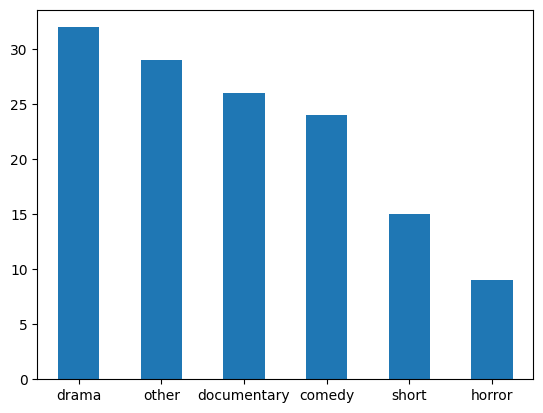

In [15]:
test_data.genre.value_counts().plot(kind="bar", rot=0)

In [22]:
my_tags = unique_genres

## Model evaluation approach
We will use confusion matrices to evaluate all classifiers

In [23]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [38]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['description'])
    predictions = classifier.predict(data_features)
    target = data['genre']
    evaluate_prediction(predictions, target)

### Baseline: bag of words, n-grams, tf-idf
Starting with some simple baselines before diving into more advanced methods.

### Bag of words
The simplest document feature is just a count of each word occurrence in a document.

We remove stop-words and use NLTK tokenizer then limit our vocabulary to 3k most frequent words.

In [27]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [29]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['description'])

CPU times: user 711 ms, sys: 22.4 ms, total: 734 ms
Wall time: 748 ms


Multi-modal logistic regression is a simple white-box classifier. We will use either logistic regression or KNN

In [35]:
%%time

logreg = linear_model.LogisticRegression(n_jobs=1, C=1, max_iter=1000)
logreg = logreg.fit(train_data_features, train_data['genre'])

CPU times: user 1.58 s, sys: 35.3 ms, total: 1.62 s
Wall time: 885 ms


In [36]:
count_vectorizer.get_feature_names()[80:90]

/home/bibin/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['adults',
 'advantage',
 'adventure',
 'adventures',
 'affair',
 'affairs',
 'affected',
 'afflicted',
 'afternoon',
 'age']

accuracy 0.4074074074074074
confusion matrix
 [[ 7  4  8  1  4  0]
 [ 1 22  2  0  1  0]
 [ 2  6 18  0  5  1]
 [ 0  1  2  1  5  0]
 [ 1  6 15  0  7  0]
 [ 3  6  2  0  4  0]]
(row=expected, col=predicted)
CPU times: user 448 ms, sys: 141 µs, total: 448 ms
Wall time: 450 ms


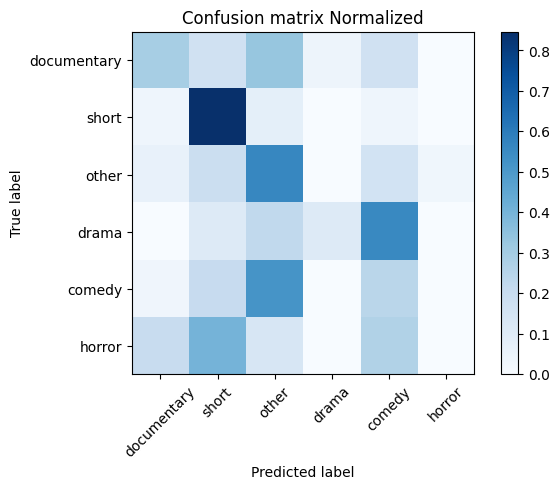

In [39]:
%%time

predict(count_vectorizer, logreg, test_data)

In [40]:
def most_influential_words(vectorizer, genre_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(logreg.coef_[genre_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]   

In [42]:
# words for the short genre
genre_tag_id = 1
print(my_tags[genre_tag_id])
most_influential_words(count_vectorizer, genre_tag_id)

short


['documentary',
 'years',
 'political',
 'art',
 'people',
 'world',
 'history',
 'unforgettable',
 'film',
 'scenes']

In [43]:
train_data_features[0]


<1x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 73 stored elements in Compressed Sparse Row format>

## Character N-grams
A character n-gram is a chunk of a document of length n. It is a poor man's tokenizer but sometimes works well. The parameter n depends on language and the corpus. We choose length between 3 and 6 characters and to only focus on 3k most popular ones.

In [44]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(train_data['description'])

logreg = logreg.fit(train_data_features, train_data['genre'])

CPU times: user 3.84 s, sys: 78.4 ms, total: 3.92 s
Wall time: 2.98 s


/home/bibin/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
n_gram_vectorizer.get_feature_names()[50:60]

/home/bibin/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[' ar',
 ' are',
 ' are ',
 ' as',
 ' as ',
 ' as a',
 ' as t',
 ' at',
 ' at ',
 ' at t']

The results are worse than using a tokenizer and bag of words. Probably due to not removing the stop words.

accuracy 0.3851851851851852
confusion matrix
 [[ 2  7  8  1  6  0]
 [ 1 18  3  1  2  1]
 [ 3  3 18  0  6  2]
 [ 0  1  3  0  4  1]
 [ 0  2 11  1 12  3]
 [ 3  2  4  1  3  2]]
(row=expected, col=predicted)


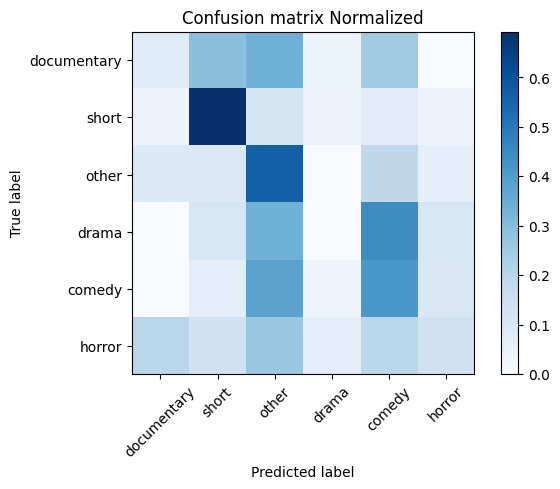

In [46]:
predict(n_gram_vectorizer, logreg, test_data)

## TF-IDF
Term Frequency - Inverse Document Frequency is a little more advanced way to count words in a document. It adjusts for document length, word frequency and most importantly for frequency of a particular word in a particular document.

In [47]:
%%time
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['description'])

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['genre'])

CPU times: user 2.05 s, sys: 31.9 ms, total: 2.08 s
Wall time: 1.54 s


/home/bibin/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
tf_vect.get_feature_names()[1000:1010]

/home/bibin/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['dreaming',
 'dreams',
 'dressed',
 'drink',
 'drinking',
 'drinks',
 'driven',
 'driver',
 'drivers',
 'drives']

accuracy 0.4148148148148148
confusion matrix
 [[ 7  5  9  0  3  0]
 [ 0 22  2  0  2  0]
 [ 6  5 14  0  5  2]
 [ 0  0  3  2  4  0]
 [ 2  3 14  0 10  0]
 [ 1  7  2  0  4  1]]
(row=expected, col=predicted)


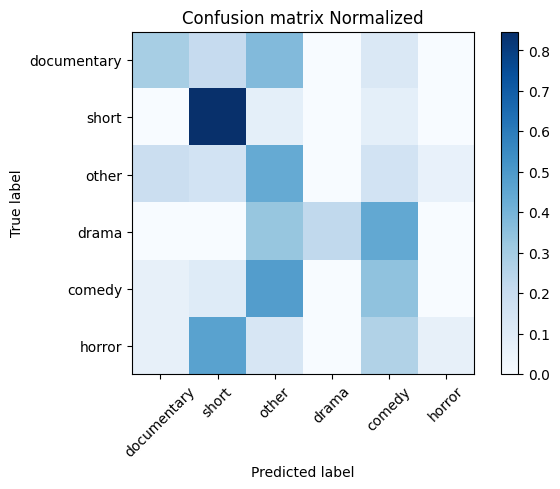

In [49]:
predict(tf_vect, logreg, test_data)

In [50]:
most_influential_words(tf_vect, 1)

/home/bibin/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['documentary',
 'film',
 'political',
 'years',
 'people',
 'art',
 'relatives',
 'award',
 'history',
 'world']

## Averaging word vectors
Now let's use more complex features rather than just counting words.

A great recent achievement of NLP is the Doc2Vec embedding. 

In [55]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [57]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['description']), tags=[r.genre]), axis=1)


In [64]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['description']), tags=[r.genre]), axis=1)

In [60]:
test_tagged.values[50]

TaggedDocument(words=['train', 'to', 'zakopané', 'is', 'true', 'love', 'story', 'that', 'lays', 'bare', 'how', 'compassion', 'and', 'intolerance', 'can', 'even', 'in', 'the', 'most', 'unusual', 'of', 'circumstances', 'be', 'one', 'written', 'and', 'directed', 'from', 'his', 'long-running', 'play', 'by', 'henry', 'jaglom', 'and', 'adapted', 'for', 'film', 'together', 'with', 'producer/editor', 'ron', 'vignone', 'the', 'film', 'reveals', 'humanity', 'in', 'the', 'most', 'unlikely', 'of', 'places', 'prejudice', 'the', 'film', 'is', 'based', 'on', 'true', 'events', 'that', 'occurred', 'in', 'the', 'life', 'of', 'henry', 'jaglom', "'s", 'father', 'as', 'he', 'crossed', 'poland', 'on', 'train', 'in', '1928', 'anti-semitism', 'was', 'at', 'that', 'time', 'rife', 'in', 'much', 'of', 'europe', 'especially', 'in', 'poland', 'in', 'train', 'to', 'zakopané', 'successful', 'young', 'russian', 'businessman', 'meets', 'captivating', 'nurse', 'in', 'the', 'polish', 'army', 'on', 'train-trip', 'to', 'w

In [65]:
%%time
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=1, vector_size=5, epochs=20, dm=1)


train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, epochs=20)) for doc in trainsent])


2023-11-16 23:49:07,301 : INFO : collecting all words and their counts
2023-11-16 23:49:07,304 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2023-11-16 23:49:07,368 : INFO : collected 9999 word types and 6 unique tags from a corpus of 542 examples and 54437 words
2023-11-16 23:49:07,371 : INFO : Creating a fresh vocabulary
2023-11-16 23:49:07,432 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1575 unique words (15.751575157515752%% of original 9999, drops 8424)', 'datetime': '2023-11-16T23:49:07.432470', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 13:09:58) \n[GCC 7.5.0]', 'platform': 'Linux-5.15.0-84-generic-x86_64-with-glibc2.31', 'event': 'prepare_vocab'}
2023-11-16 23:49:07,435 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 41485 word corpus (76.20735896540955%% of original 54437, drops 12952)', 'datetime': '2023-11-16T23:49:07.435072', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep

CPU times: user 3.89 s, sys: 24.6 ms, total: 3.91 s
Wall time: 3.9 s


 Interesting thing about doc2vec is that we need to run gradient descent during prediction to infer the vector for an unseen document. An unseen document is initially assigned a random vector and then this vector fit by gradient descent. Because of this randomness we get different vectors on re-runs of the next cell.

Consequently, the accuracy of logistic regression changes when the test set vectors change

In [67]:
%%time
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, epochs=20)) for doc in testsent])

CPU times: user 496 ms, sys: 0 ns, total: 496 ms
Wall time: 495 ms


accuracy 0.3851851851851852
confusion matrix
 [[ 8  6  5  1  2  2]
 [ 2 15  3  0  1  5]
 [ 5  5 15  1  3  3]
 [ 1  0  1  0  6  1]
 [ 3  5  5  2 10  4]
 [ 1  3  5  0  2  4]]
(row=expected, col=predicted)


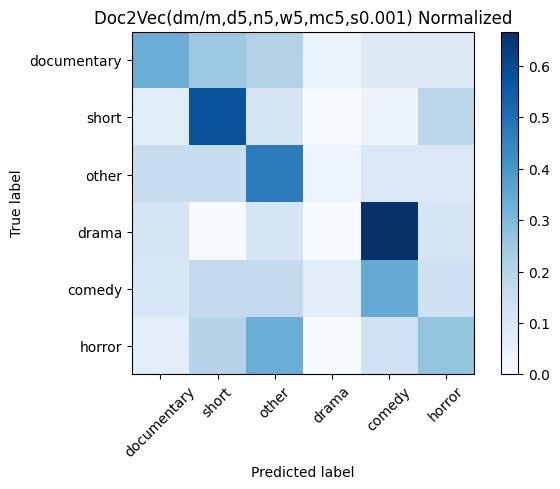

In [68]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))

KNN gives a lower accuracy than logistic regression.

<timed exec>:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).


accuracy 0.1037037037037037
confusion matrix
 [[ 1  0  1  0  0 22]
 [ 0  1  0  0  0 25]
 [ 0  0  0  1  0 31]
 [ 1  0  0  0  0  8]
 [ 2  0  0  2  0 25]
 [ 0  0  2  1  0 12]]
(row=expected, col=predicted)
CPU times: user 390 ms, sys: 3.89 ms, total: 394 ms
Wall time: 407 ms


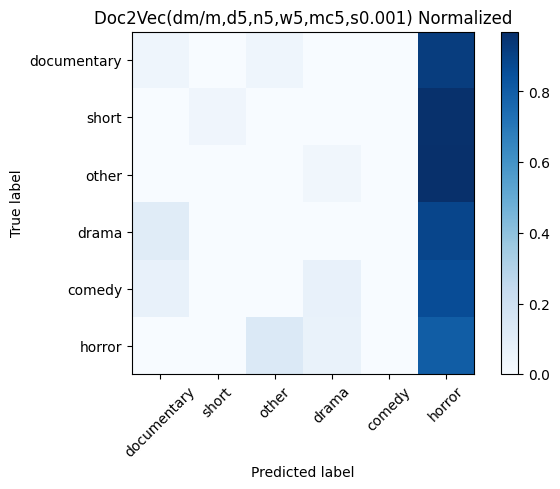

In [69]:
%%time 
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
evaluate_prediction(knn_test_predictions, test_targets, str(doc2vec_model))

### Deep IR

Doc2vec gives us a vector for each genre so we can see which genres are close together.

In [73]:
import re
contractions = re.compile(r"'|-|\"")
# all non alphanumeric
symbols = re.compile(r'(\W+)', re.U)
# single character removal
singles = re.compile(r'(\s\S\s)', re.I|re.U)
# separators (any whitespace)
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    return text

# sentence splitter
alteos = re.compile(r'([!\?])')
def sentences(l):
    l = alteos.sub(r' \1 .', l).rstrip("(\.)*\n")
    return l.split(".")

In [74]:
def plots(label):
    my_df = None
    if label=='training':
        my_df = train_data
    else:
        my_df = test_data
    for i, row in my_df.iterrows():
        yield {'y':row['genre'],\
        'x':[clean(s).split() for s in sentences(row['description'])]}

In [75]:
%%time
# The corpus is small so can be read into memory
revtrain = list(plots("training"))
revtest = list(plots("test"))

CPU times: user 419 ms, sys: 12.1 ms, total: 431 ms
Wall time: 441 ms


In [76]:
# shuffle training set for unbiased word2vec training
np.random.shuffle(revtrain)

In [77]:
def tag_sentences(reviews, stars=my_tags):  
    for r in reviews:
        if r['y'] in stars:
            for s in r['x']:
                yield s


In [78]:
next(tag_sentences(revtrain, my_tags[0]))

['an',
 'incredible',
 'journey',
 'through',
 'the',
 'postcommunist',
 'societies',
 'left',
 'fragmented',
 'by',
 'the',
 'collapse',
 'of',
 'the',
 'soviet',
 'empire',
 'reveals',
 'an',
 'undiscovered',
 'world',
 'where',
 'time',
 'stood',
 'still']

In [83]:
%%time 
## training
from gensim.models import Word2Vec
import multiprocessing

## create a w2v learner 
basemodel = Word2Vec(
    workers=multiprocessing.cpu_count(), # use your cores
    epochs=100, # epochs = sweeps of SGD through the data; more is better
    hs=1, negative=0, # we only have scoring for the hierarchical softmax setup
)

print(basemodel)
basemodel.build_vocab(tag_sentences(revtrain)) 
from copy import deepcopy
genremodels = [deepcopy(basemodel) for i in range(len(my_tags))]
for i in range(len(my_tags)):
    slist = list(tag_sentences(revtrain, my_tags[i]))
    print(my_tags[i], "genre (", len(slist), ")")
    genremodels[i].train( slist, total_examples=len(slist) ,epochs = basemodel.epochs)
# get the probs (note we give docprob a list of lists of words, plus the models)

2023-11-16 23:58:57,633 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=100, alpha=0.025)', 'datetime': '2023-11-16T23:58:57.633668', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 13:09:58) \n[GCC 7.5.0]', 'platform': 'Linux-5.15.0-84-generic-x86_64-with-glibc2.31', 'event': 'created'}
2023-11-16 23:58:57,639 : INFO : collecting all words and their counts
2023-11-16 23:58:57,646 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-11-16 23:58:57,755 : INFO : collected 10141 word types from a corpus of 53654 raw words and 3046 sentences
2023-11-16 23:58:57,761 : INFO : Creating a fresh vocabulary
2023-11-16 23:58:57,821 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1567 unique words (15.452125036978602%% of original 10141, drops 8574)', 'datetime': '2023-11-16T23:58:57.821435', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 13:09:58) \n[GCC 7.5.0]', 'platform': 'Linux-5.15.0-84-gen

Word2Vec(vocab=0, vector_size=100, alpha=0.025)


2023-11-16 23:58:57,905 : INFO : deleting the raw counts dictionary of 10141 items
2023-11-16 23:58:57,909 : INFO : sample=0.001 downsamples 45 most-common words
2023-11-16 23:58:57,912 : INFO : Word2Vec lifecycle event {'msg': 'downsampling leaves estimated 27319.974102366046 word corpus (67.6%% of prior 40439)', 'datetime': '2023-11-16T23:58:57.912213', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 13:09:58) \n[GCC 7.5.0]', 'platform': 'Linux-5.15.0-84-generic-x86_64-with-glibc2.31', 'event': 'prepare_vocab'}
2023-11-16 23:58:57,923 : INFO : constructing a huffman tree from 1567 words
2023-11-16 23:58:58,015 : INFO : built huffman tree with maximum node depth 13
2023-11-16 23:58:58,017 : INFO : estimated required memory for 1567 words and 100 dimensions: 2350500 bytes
2023-11-16 23:58:58,018 : INFO : resetting layer weights
2023-11-16 23:58:58,020 : INFO : Word2Vec lifecycle event {'update': False, 'trim_rule': 'None', 'datetime': '2023-11-16T23:58:58.020714', 'gensim': 

documentary genre ( 780 )


2023-11-16 23:58:58,316 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-11-16 23:58:58,322 : INFO : EPOCH - 4 : training on 15121 raw words (7445 effective words) took 0.0s, 168915 effective words/s
2023-11-16 23:58:58,348 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-11-16 23:58:58,350 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-11-16 23:58:58,363 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-11-16 23:58:58,381 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-11-16 23:58:58,386 : INFO : EPOCH - 5 : training on 15121 raw words (7481 effective words) took 0.1s, 141431 effective words/s
2023-11-16 23:58:58,417 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-11-16 23:58:58,423 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-11-16 23:58:58,436 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-11-

short genre ( 156 )


2023-11-16 23:59:02,646 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-11-16 23:59:02,649 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-11-16 23:59:02,650 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-11-16 23:59:02,653 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-11-16 23:59:02,655 : INFO : EPOCH - 11 : training on 2744 raw words (1333 effective words) took 0.0s, 105861 effective words/s
2023-11-16 23:59:02,668 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-11-16 23:59:02,669 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-11-16 23:59:02,672 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-11-16 23:59:02,676 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-11-16 23:59:02,679 : INFO : EPOCH - 12 : training on 2744 raw words (1336 effective words) took 0.0s, 93860 effective words/s
2023-11-1

other genre ( 699 )


2023-11-16 23:59:04,412 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-11-16 23:59:04,414 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-11-16 23:59:04,416 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-11-16 23:59:04,429 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-11-16 23:59:04,430 : INFO : EPOCH - 7 : training on 11268 raw words (5775 effective words) took 0.0s, 204105 effective words/s
2023-11-16 23:59:04,443 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-11-16 23:59:04,446 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-11-16 23:59:04,448 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-11-16 23:59:04,462 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-11-16 23:59:04,464 : INFO : EPOCH - 8 : training on 11268 raw words (5799 effective words) took 0.0s, 206388 effective words/s
2023-11-

drama genre ( 885 )


2023-11-16 23:59:07,526 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-11-16 23:59:07,532 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-11-16 23:59:07,543 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-11-16 23:59:07,547 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-11-16 23:59:07,549 : INFO : EPOCH - 7 : training on 15143 raw words (7917 effective words) took 0.0s, 260199 effective words/s
2023-11-16 23:59:07,565 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-11-16 23:59:07,566 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-11-16 23:59:07,576 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-11-16 23:59:07,582 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-11-16 23:59:07,583 : INFO : EPOCH - 8 : training on 15143 raw words (7877 effective words) took 0.0s, 275330 effective words/s
2023-11-

comedy genre ( 358 )


2023-11-16 23:59:10,984 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-11-16 23:59:10,985 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-11-16 23:59:10,986 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-11-16 23:59:10,993 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-11-16 23:59:10,994 : INFO : EPOCH - 9 : training on 6630 raw words (3384 effective words) took 0.0s, 219096 effective words/s
2023-11-16 23:59:11,005 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-11-16 23:59:11,007 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-11-16 23:59:11,008 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-11-16 23:59:11,021 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-11-16 23:59:11,022 : INFO : EPOCH - 10 : training on 6630 raw words (3393 effective words) took 0.0s, 140955 effective words/s
2023-11-1

horror genre ( 168 )


2023-11-16 23:59:13,487 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-11-16 23:59:13,488 : INFO : EPOCH - 13 : training on 2748 raw words (1431 effective words) took 0.0s, 127723 effective words/s
2023-11-16 23:59:13,496 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-11-16 23:59:13,497 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-11-16 23:59:13,499 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-11-16 23:59:13,503 : INFO : worker thread finished; awaiting finish of 0 more threads
2023-11-16 23:59:13,504 : INFO : EPOCH - 14 : training on 2748 raw words (1466 effective words) took 0.0s, 138036 effective words/s
2023-11-16 23:59:13,514 : INFO : worker thread finished; awaiting finish of 3 more threads
2023-11-16 23:59:13,516 : INFO : worker thread finished; awaiting finish of 2 more threads
2023-11-16 23:59:13,517 : INFO : worker thread finished; awaiting finish of 1 more threads
2023-11-

CPU times: user 21.2 s, sys: 1.19 s, total: 22.4 s
Wall time: 17.5 s


Now we will compute most likely class for a plot using Bayes' Theorem formula.

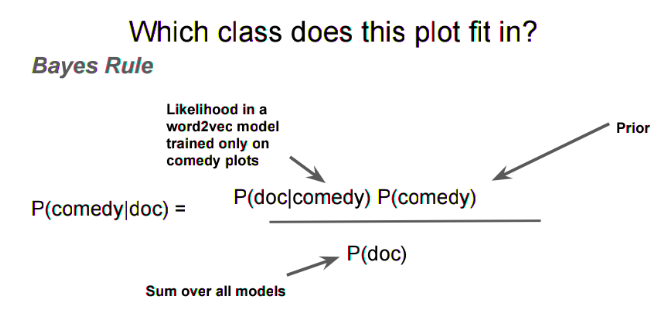

For any new sentence we can obtain its likelihood (lhd; actually, the composite likelihood approximation; see the paper) using the score function in the word2vec class. We get the likelihood for each sentence in the first test review, then convert to a probability over star ratings. Every sentence in the review is evaluated separately and the final star rating of the review is an average vote of all the sentences

In [84]:
"""
docprob takes two lists
* docs: a list of documents, each of which is a list of sentences
* models: the candidate word2vec models (each potential class)

it returns the array of class probabilities.  Everything is done in-memory.
"""


def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob

In [85]:
%%time
## predict
probs = docprob( [r['x'] for r in revtest], genremodels )  
predictions = probs.idxmax(axis=1).apply(lambda x: my_tags[x])

2023-11-17 00:01:57,853 : INFO : scoring sentences with 4 workers on 1567 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2023-11-17 00:01:57,872 : INFO : reached end of input; waiting to finish 8 outstanding jobs
2023-11-17 00:01:57,967 : INFO : scoring 713 sentences took 0.1s, 6699 sentences/s
2023-11-17 00:01:57,970 : INFO : scoring sentences with 4 workers on 1567 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2023-11-17 00:01:57,981 : INFO : reached end of input; waiting to finish 8 outstanding jobs
2023-11-17 00:01:58,064 : INFO : scoring 713 sentences took 0.1s, 7862 sentences/s
2023-11-17 00:01:58,068 : INFO : scoring sentences with 4 workers on 1567 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2023-11-17 00:01:58,076 : INFO : reached end of input; waiting to finish 8 outstanding jobs
2023-11-17 00:01:58,124 : INFO : scoring 713 sentences took 0.1s, 13321 sentences/s
2023-11-17 00:01:58,127 : INFO : 

CPU times: user 467 ms, sys: 116 ms, total: 583 ms
Wall time: 418 ms


<Axes: title={'center': 'out-of-sample prob positive for documentary'}, xlabel='true genres'>

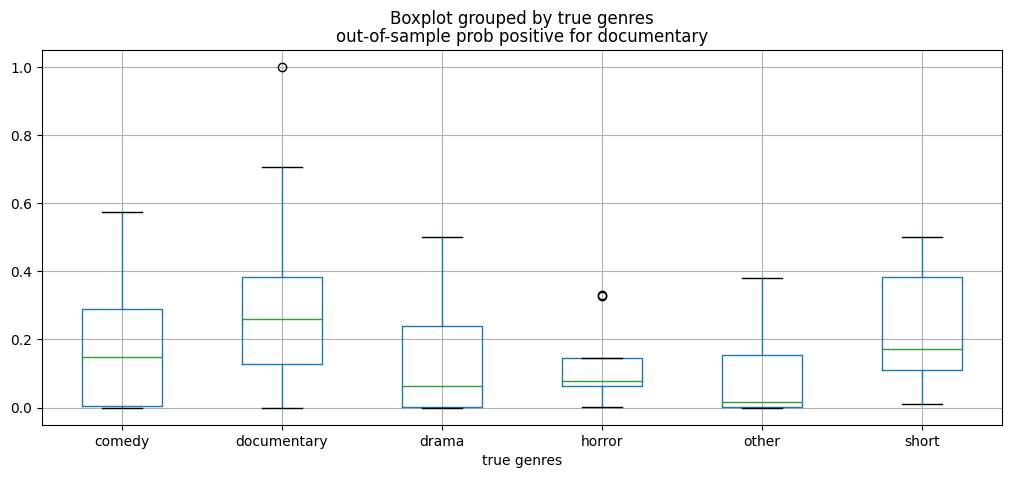

In [86]:
tag_index = 0
col_name = "out-of-sample prob positive for " + my_tags[tag_index]
probpos = pd.DataFrame({col_name:probs[[tag_index]].sum(axis=1), 
                        "true genres": [r['y'] for r in revtest]})
probpos.boxplot(col_name,by="true genres", figsize=(12,5))

In [87]:
target = [r['y'] for r in revtest]

accuracy 0.22962962962962963
confusion matrix
 [[ 4  1  4  3  2 10]
 [ 2 12  1  2  4  5]
 [ 3  5  9  1  4 10]
 [ 0  2  3  1  1  2]
 [ 6  2  8  4  3  6]
 [ 2  3  5  1  2  2]]
(row=expected, col=predicted)


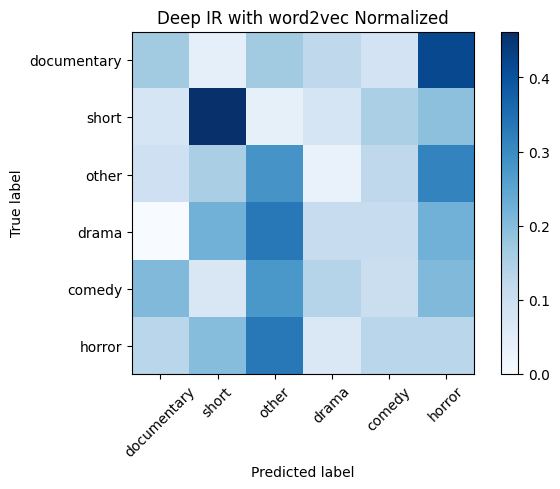

In [88]:
evaluate_prediction(predictions, target, "Deep IR with word2vec")